In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '338697',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/4Kr0RereFqdS29qe-mNYkQ__thumb/img/HCQGvP8maKFhqx0cFvkJ18AYTx8=/fit-in/200x150/filters:strip_icc()/pic6192204.png',
  'name': 'CATAN: 3D Edition',
  'yearpublished': '2021'},
 {'id': '318184',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/MN0OvKejfrfwD6bupQHp4g__thumb/img/MVh7xtQ4l17hprI4mFIk9Kswk6s=/fit-in/200x150/filters:strip_icc()/pic5623566.jpg',
  'name': 'Imperium: Classics',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 24)
page number = 20 (max: 100, len: 16)
page number = 30 (max: 100, len: 11)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 44, len: 1)
comments_df shape: (90653, 4)


,id,username,rating,value
0,338697,Fuzzel,3,Hässlicher 3D Plastik Murks. Inhaltlich nichts...
1,338697,Johnathan Ray,8,Catan got me into the hobby a dime ago. The re...
2,338697,visard,7,See [gameid=13].
3,338697,wouter7048,N/A,Only the base 3-4p game...
4,318184,Across the Rhine,N/A,Via Book Depository
...,...,...,...,...
90648,167791,z_zadar,9,Some games are so much fun. Others can be a li...
90649,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
90650,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
90651,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15347 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         15105
9          14117
8          11747
N/A         6453
7           6394
           ...  
8.0974         1
7.835          1
4.6            1
9.77           1
9.50667        1
Name: rating, Length: 509, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(68853, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6453, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'weight!upto4.5; unlocking! continuously fantastical combining theatrical poolbuilding spreading convincing helpful risky expandable tactile; favoured over Root?, Legends of Andor, Mechs vs Minions?, Dawn of Peacemakers?'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"0 balance, I still can't understand how it could be rated that high.. I had 5 games and the balance was off in all of them manage to win it with 100 points difference more than once..."

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
34/34 - 4s - loss: 0.6533 - accuracy: 0.6504 - val_loss: 0.5143 - val_accuracy: 0.8497
Epoch 2/100
34/34 - 2s - loss: 0.4753 - accuracy: 0.8504 - val_loss: 0.4389 - val_accuracy: 0.8516
Epoch 3/100
34/34 - 2s - loss: 0.4038 - accuracy: 0.8517 - val_loss: 0.3826 - val_accuracy: 0.8525
Epoch 4/100
34/34 - 2s - loss: 0.3472 - accuracy: 0.8525 - val_loss: 0.3481 - val_accuracy: 0.8529
Epoch 5/100
34/34 - 2s - loss: 0.3072 - accuracy: 0.8545 - val_loss: 0.3302 - val_accuracy: 0.8538
Epoch 6/100
34/34 - 2s - loss: 0.2787 - accuracy: 0.8588 - val_loss: 0.3217 - val_accuracy: 0.8577
Epoch 7/100
34/34 - 2s - loss: 0.2560 - accuracy: 0.8790 - val_loss: 0.3180 - val_accuracy: 0.8735
Epoch 8/100
34/34 - 2s - loss: 0.2335 - accuracy: 0.9053 - val_loss: 0.3147 - val_accuracy: 0.8741
Epoch 9/100
34/34 - 2s - loss: 0.2061 - accuracy: 0.9207 - val_loss: 0.3211 - val_accuracy: 0.8744
Epoch 10/100
34/34 - 2s - loss: 0.1842 - accuracy: 0.9309 - val_loss: 0.3317 - val_accuracy: 0.8742
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F88ED20C70>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

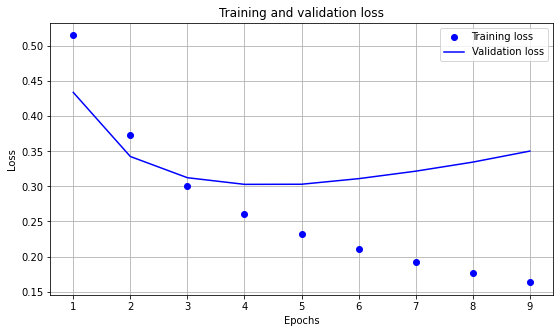

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

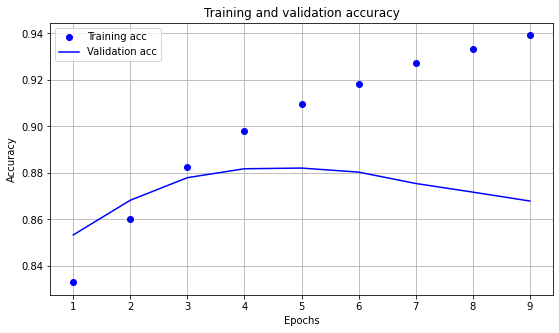

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"weight!upto4.5; unlocking! continuously fantastical combining theatrical poolbuilding spreading convincing helpful risky expandable tactile; favoured over Root?, Legends of Andor, Mechs vs Minions?, Dawn of Peacemakers?"
score: 1.000000
actual: 1

input:
"Everdell is amazing. The artwork is adorable - but don’t let the cute theme deceive you - the card play is surprisingly more deep and interesting than I anticipated. Even after all of the plays, I’m still discovering new combos and trying to figure out the best strategy"
score: 1.000000
actual: 1

input:
"1. Long complex game - Resource management"
score: 1.000000
actual: 1

input:
"I think the more I play this the higher it will go. I played two-handed, but I can't stop thinking about it..."
score: 1.000000
actual: 1

input:
"Only one play, but I enjoyed it.  It took a while to learn, but once you do go through everything the turns are really straightforward.  It's weird how all the boards are different and get mixed/matched 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"Just backed the Kickstarter for the 2nd printing and totally excited to get it!"
score: 1.000000

input:
"Kickstarter project. Beware of biased reviews and ratings from backers."
score: 0.000000

input:
"KS edition with Book of the Dead, Great Old Ones, all addons/stretch goals"
score: 1.000000

input:
"Very curious how the legacy aspect reflects roleplaying experiences I've had before."
score: 1.000000

input:
"christmas 2020 gift from long and tram"
score: 1.000000

input:
"it is currently being shipped to me as a gift, but I played it already with a friend. this is the coop I like because there is a need for everyone to take part in decisions and acting, while I experienced various times that in coop there is one leader and everyone does what they says. I love how each spirit has a different design space"
score: 1.000000

input:
"(1) Available to Play, (Yellow) (2) Available to Play, (Red)"
score: 1.000000

input:
"Own the [boardgame=218127]Hellas & Elysium[/boardga

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FB430DE580>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.62


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.98


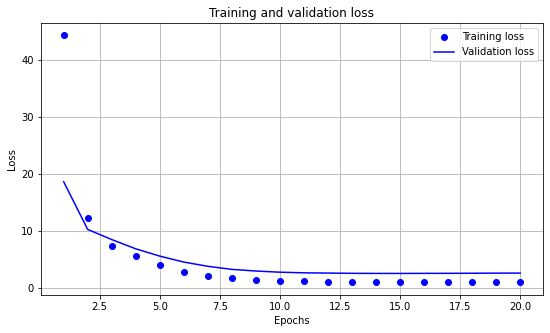

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

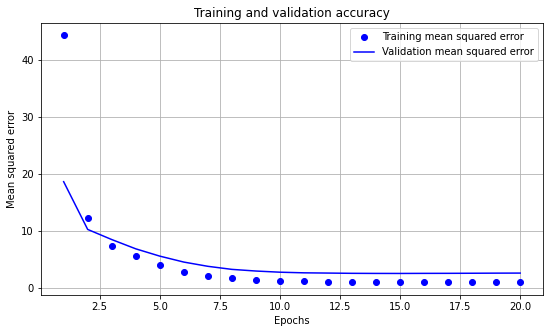

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"weight!upto4.5; unlocking! continuously fantastical combining theatrical poolbuilding spreading convincing helpful risky expandable tactile; favoured over Root?, Legends of Andor, Mechs vs Minions?, Dawn of Peacemakers?"
score: 9.63
actual: 9.85 

input: 
"Everdell is amazing. The artwork is adorable - but don’t let the cute theme deceive you - the card play is surprisingly more deep and interesting than I anticipated. Even after all of the plays, I’m still discovering new combos and trying to figure out the best strategy"
score: 9.01
actual: 9.00 

input: 
"1. Long complex game - Resource management"
score: 7.61
actual: 9.00 

input: 
"I think the more I play this the higher it will go. I played two-handed, but I can't stop thinking about it..."
score: 8.43
actual: 7.00 

input: 
"Only one play, but I enjoyed it.  It took a while to learn, but once you do go through everything the turns are really straightforward.  It's weird how all the boards are different and get mixed/mat

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"+ The Exiles and Partisans Deck & The Vagabond Pack"
    reg score: 8.73
    clf score: 1

"+ La Armada + Flying Dutchman + Oportunista"
    reg score: 6.89
    clf score: 1

"Propiedad EL Club Dante; Propiedad Socio 0035"
    reg score: 9.00
    clf score: 1

"Backed Middara on Kickstarter.  All 3 acts"
    reg score: 8.91
    clf score: 1

"preordered for my by a wonderful friend!!"
    reg score: 6.37
    clf score: 0

"Asmodee, Frühjahr 2021 - April 2021; inkl. Captain America, Ms. Marvel & Black Widow"
    reg score: 7.06
    clf score: 1

"w/ Broken Token Insert, Legendary box, metal coins"
    reg score: 8.85
    clf score: 1

"I am looking to buy for a very cheap price for (likely a used copy)"
    reg score: 8.28
    clf score: 1

"ENTREGA A LOS BACKERS EN AGOSTO 2021"
    reg score: 7.57
    clf score: 1

"Have only played demo but a solid update to one of my favorite games: keeps what works and changes what didn't.  I don't like the new art cause cartoons ruin my evocative 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.35 |           3549 |
| 167355 |          8.42 |           1847 |
| 167791 |          8.21 |           8307 |
| 169427 |          8.66 |            244 |
| 169786 |          8.10 |           7363 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.11 |            319 |
| 167355 |          8.17 |            215 |
| 167791 |          8.17 |            440 |
| 169427 |          8.37 |             74 |
| 169786 |          8.08 |            593 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/4Kr0Rer...","<a href=""https://boardgamegeek.com/boardgame/3...",6.00000,NaN,NaN,1,2021
1,"<img src=""https://cf.geekdo-images.com/MN0OvKe...","<a href=""https://boardgamegeek.com/boardgame/3...",7.62500,7.743136,7.640409,2,2021
2,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.86142,8.200111,7.969310,3,2021
3,"<img src=""https://cf.geekdo-images.com/GGXq2lR...","<a href=""https://boardgamegeek.com/boardgame/2...",6.20000,7.129473,6.839013,4,NaN
4,"<img src=""https://cf.geekdo-images.com/NPWdxDD...","<a href=""https://boardgamegeek.com/boardgame/3...",7.93200,8.168390,8.007215,5,2020


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,CATAN: 3D Edition,6.00000,NaN,NaN,1,2021
2,,Imperium: Classics,7.62500,7.743136,7.640409,2,2021
3,,Oath: Chronicles of Empire and Exile,7.86142,8.200111,7.969310,3,2021
4,,Arydia: The Paths We Dare Tread,6.20000,7.129473,6.839013,4,NaN
5,,The LOOP,7.93200,8.168390,8.007215,5,2020


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Now or Never,10.000000,7.696962,8.080802,15,2021
2,,Deliverance,9.689474,9.030303,9.641242,48,2021
3,,Imperium: Legends,9.428571,7.412682,8.980596,9,2021
4,,Eclipse: Second Dawn for the Galaxy,8.726006,7.840591,8.590551,42,2020
5,,Brass: Birmingham,8.678443,8.085606,8.625700,28,2018


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Deliverance,9.689474,9.030303,9.641242,48,2021
2,,Imperium: Legends,9.428571,7.412682,8.980596,9,2021
3,,Brass: Birmingham,8.678443,8.085606,8.625700,28,2018
4,,Middara: Unintentional Malum – Act 1,8.660370,8.373304,8.593568,36,2019
5,,Eclipse: Second Dawn for the Galaxy,8.726006,7.840591,8.590551,42,2020


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Seems to be very popular but does not appeal to me at all. I guess that mainly I am not that keen on cooperative games."
score: 4.93

"Opinió després de veure un How to Play: No m'acaba d'agradar. Típic hibrid de KS poc cohesionat i amb components impressionants, però el joc es veu poc polit."
score: 5.91

"Definitely pretty. Very boring though. Lacked something to grab hold me and my various play groups. 0/6 enjoyed this. (Played x5)"
score: 6.03

"bag-engine-building, push-your luck with some variability in different color powers start with mostly white chips. draw too many white chips and you will bust. busting means you can only complete 1 of your 2 actions so not completely bust."
score: 6.06

"Jury is still out on if I like this. Still confusing! I've never felt like I've played and entire scenario correctly. Going to do Dunwich and make the call after that. "
score: 6.72

"Successor to Brass, and supposedly better than the original. VERY interested to try this one and eager to 

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test